In [72]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [317]:
from fastai.structured import *
from fastai.column_data import *
import tensorflow as tf
np.set_printoptions(threshold=50, edgeitems=20)

import keras
from keras import metrics
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam, RMSprop
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.utils import plot_model
from keras.models import load_model
from IPython.display import display

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn import metrics


In [228]:
DATAPATH='/home/ubuntu/Skynet/details1.csv'

In [293]:
#data = pd.read_csv(DATAPATH, delimiter=",")

#x = data["StartTime"].values
#y = data["CPUAverage"].values

[1535270460 1535273640 1535276820 1535280000 1535346780 1535304300 1535307480 1535310660 1535313840
 1535336100 1535339280 1535329740 1535332920 1535278620 1535304060 1535281800 1535284980 1535288160
 1535261580 1535307240 ... 1535283900 1535271180 1535305140 1535343300 1535276400 1535334780 1535322060
 1535267880 1535289120 1535341080 1535287980 1535300700 1535338860 1535306880 1535294160 1535345040
 1535304660 1535291940 1535272800 1535310960]
[0.02 0.02 0.02 0.02 0.02 0.02 0.03 0.02 0.02 0.02 0.02 0.02 0.02 0.03 0.02 0.02 0.02 0.02 0.02 0.02 ... 0.02
 0.03 0.03 0.05 0.03 0.04 0.04 0.03 0.03 0.05 0.03 0.03 0.04 0.04 0.02 0.04 0.03 0.03 0.03 0.04]
41745
41745


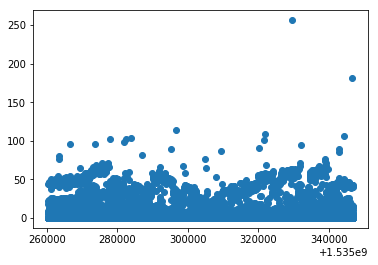

In [230]:
#plt.scatter(x,y)
#plt.show()

In [232]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [233]:
display_all(data.head())
display_all(data.tail())

,StartTime,ServiceName,AllocatedCPU,HealthyHosts,CPUAverage
0,1535270460,Prod-SamsungCTV-EcsService-1QKI54202SHBC,1000,1,0.02
1,1535273640,Prod-SamsungCTV-EcsService-1QKI54202SHBC,1000,1,0.02
2,1535276820,Prod-SamsungCTV-EcsService-1QKI54202SHBC,1000,1,0.02
3,1535280000,Prod-SamsungCTV-EcsService-1QKI54202SHBC,1000,1,0.02
4,1535346780,Prod-SamsungCTV-EcsService-1QKI54202SHBC,1000,1,0.02


,StartTime,ServiceName,AllocatedCPU,HealthyHosts,CPUAverage
41740,1535345040,Prod-LoadBalancers-PublicEcsService-122OZOVI0LMZ5,25,2,0.04
41741,1535304660,Prod-LoadBalancers-PublicEcsService-122OZOVI0LMZ5,25,2,0.03
41742,1535291940,Prod-LoadBalancers-PublicEcsService-122OZOVI0LMZ5,25,2,0.03
41743,1535272800,Prod-LoadBalancers-PublicEcsService-122OZOVI0LMZ5,25,2,0.03
41744,1535310960,Prod-LoadBalancers-PublicEcsService-122OZOVI0LMZ5,25,2,0.04


In [281]:
#display_all(data.describe(include='all').T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
StartTime,41745,NaN,NaN,NaN,1.5353e+09,24924.4,1.53526e+09,1.53528e+09,1.5353e+09,1.53533e+09,1.53535e+09
ServiceName,4318,3,Prod-7TravelLoadBalancer-PublicEcsService-WLXS...,1440,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AllocatedCPU,41745,NaN,NaN,NaN,827.785,755.865,25,200,500,1000,3000
HealthyHosts,41745,NaN,NaN,NaN,1.34212,0.823776,0,1,1,2,6
CPUAverage,41745,NaN,NaN,NaN,3.04241,9.42797,0,0.01,0.06,0.55,256.23


In [290]:
#??RandomForestRegressor

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
5       NaN
6       NaN
7       NaN
8       NaN
9       NaN
10      NaN
11      NaN
12      NaN
13      NaN
14      NaN
15      NaN
16      NaN
17      NaN
18      NaN
19      NaN
20      NaN
21      NaN
22      NaN
23      NaN
24      NaN
25      NaN
26      NaN
27      NaN
28      NaN
29      NaN
         ..
41715   NaN
41716   NaN
41717   NaN
41718   NaN
41719   NaN
41720   NaN
41721   NaN
41722   NaN
41723   NaN
41724   NaN
41725   NaN
41726   NaN
41727   NaN
41728   NaN
41729   NaN
41730   NaN
41731   NaN
41732   NaN
41733   NaN
41734   NaN
41735   NaN
41736   NaN
41737   NaN
41738   NaN
41739   NaN
41740   NaN
41741   NaN
41742   NaN
41743   NaN
41744   NaN
Name: CPUAverage, Length: 41745, dtype: float64


In [294]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(bah.drop('CPUAverage', axis=1), data.CPUAverage)

,StartTime,AllocatedCPU,HealthyHosts,CPUAverage
0,1535270460,1000,1,0.02
1,1535273640,1000,1,0.02
2,1535276820,1000,1,0.02
3,1535280000,1000,1,0.02
4,1535346780,1000,1,0.02


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [296]:
##??data.to_feather

In [321]:
####temp####
data = pd.read_csv(DATAPATH, delimiter=",")

#this is important
train_cats(data)

In [255]:
data.ServiceName.cat.categories

Index(['DevTest-Auth2-Swagger-EcsService-1E783YC4FE67B',
       'Prod-7TravelLoadBalancer-PublicEcsService-WLXSEV8V65T5',
       'Prod-Auth2-Swagger-EcsService-1Q4EIY6JKMY1F',
       'Prod-Auth2-Webhooks-EcsService-13IPY2U5NWSPP',
       'Prod-LoadBalancers-PrivateEcsService-1S0YPBMZZDS01',
       'Prod-LoadBalancers-PublicEcsService-122OZOVI0LMZ5',
       'Prod-NextApi-EcsService-M30E9NDQQPCA',
       'Prod-PS4CTV-EcsService-ZH43H1HWY90',
       'Prod-SamsungCTV-EcsService-1QKI54202SHBC',
       'Prod-SevenLiveLoadBalancers-PrivateEcsService-CQBEA0DKP5TP',
       'Prod-SevenLiveLoadBalancers-PublicEcsService-1EH1U970VGF0N',
       'Prod-SevenPlusLoadBalancers-PrivateEcsService-R09F4PWXELV0',
       'Prod-SevenPlusLoadBalancers-PublicEcsService-1B2LK1FYG184Q',
       'Prod-SonyCTV-EcsService-K8W30D0N480X',
       'Prod-SwmDigitalLb-PrivateEcsService-1WRFVHLAVLTI1',
       'Prod-SwmDigitalLb-PublicEcsService-CHGYJWUHC5Z1',
       'Production-Auth2-EcsService-1JUTA1SXLCGOK',
       'Prod

In [298]:
print(data.isnull().sum())

StartTime       0
ServiceName     0
AllocatedCPU    0
HealthyHosts    0
CPUAverage      0
dtype: int64


In [297]:
#??os
#??proc_df  
#display_all(data.isnull().sum().sort_index()/len(data))

AllocatedCPU    0.0
CPUAverage      0.0
HealthyHosts    0.0
ServiceName     0.0
StartTime       0.0
dtype: float64

In [322]:
os.makedirs('tmp', exist_ok=True)
data.to_feather('tmp/sams')

In [323]:
#??proc_df
#shouldnt need to do this, but bah
data = pd.read_feather('tmp/sams')
#display_all(data)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


,StartTime,ServiceName,AllocatedCPU,HealthyHosts,CPUAverage
0,1535270460,Prod-SamsungCTV-EcsService-1QKI54202SHBC,1000,1,0.02
1,1535273640,Prod-SamsungCTV-EcsService-1QKI54202SHBC,1000,1,0.02
2,1535276820,Prod-SamsungCTV-EcsService-1QKI54202SHBC,1000,1,0.02
3,1535280000,Prod-SamsungCTV-EcsService-1QKI54202SHBC,1000,1,0.02
4,1535346780,Prod-SamsungCTV-EcsService-1QKI54202SHBC,1000,1,0.02
5,1535304300,Prod-SamsungCTV-EcsService-1QKI54202SHBC,1000,1,0.02
6,1535307480,Prod-SamsungCTV-EcsService-1QKI54202SHBC,1000,1,0.03
7,1535310660,Prod-SamsungCTV-EcsService-1QKI54202SHBC,1000,1,0.02
8,1535313840,Prod-SamsungCTV-EcsService-1QKI54202SHBC,1000,1,0.02
9,1535336100,Prod-SamsungCTV-EcsService-1QKI54202SHBC,1000,1,0.02


In [324]:
df, y, nas = proc_df(data, 'CPUAverage')

In [341]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(df,y)
m.score(df,y)

df.columns

Index(['StartTime', 'ServiceName', 'AllocatedCPU', 'HealthyHosts'], dtype='object')

In [326]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

#training sset
n_valid = 12000  # same as Kaggle's test set size
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(data, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((29745, 4), (29745,), (12000, 4))

In [342]:
#def rmse(x,y): return math.sqrt(((x-y)**2).mean())

#def print_score(m):
#    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
#                m.score(X_train, y_train), m.score(X_valid, y_valid)]
#    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
#    print(res)
    
def print_score(m):
    res = [m.predict(X_train), m.predict(X_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [343]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 336 ms, sys: 0 ns, total: 336 ms
Wall time: 110 ms
[array([0.164  , 0.02   , 0.022  , 0.0226 , 0.02   , 0.02   , 0.0205 , 0.02   , 0.02   , 0.0225 , 0.02   ,
       0.02   , 0.02033, 0.02142, 0.02   , 0.02   , 0.02   , 0.02   , 0.02   , 0.02033, ..., 0.04   ,
       0.04   , 0.033  , 0.032  , 0.03461, 0.035  , 0.06   , 0.033  , 0.035  , 0.042  , 0.03   , 0.031  ,
       0.034  , 0.039  , 0.061  , 0.029  , 0.032  , 0.052  , 0.037  , 0.027  ]), array([0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
       0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , ..., 0.05758,
       0.057  , 0.072  , 0.289  , 0.062  , 0.076  , 0.046  , 0.049  , 0.06   , 0.078  , 0.059  , 0.051  ,
       0.069  , 0.087  , 0.06   , 0.06585, 0.065  , 0.057  , 0.057  , 0.05747]), 0.9438087560028284, -0.16181457022991672]


In [331]:
df_trn, y_trn, nas = proc_df(data, 'CPUAverage', subset=30000, na_dict=nas)
X_train, _ = split_vals(df_trn, 20000)
y_train, _ = split_vals(y_trn, 20000)

In [332]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 324 ms, sys: 0 ns, total: 324 ms
Wall time: 110 ms
[array([0.18   , 0.02   , 0.023  , 0.0255 , 0.052  , 0.02   , 0.02   , 0.02   , 0.021  , 0.021  , 0.02   ,
       0.02   , 0.0205 , 0.02   , 0.02   , 0.021  , 0.02   , 0.02   , 0.02   , 0.069  , ..., 0.039  ,
       0.038  , 0.018  , 0.034  , 0.03717, 0.039  , 0.06   , 0.034  , 0.032  , 0.04   , 0.03   , 0.033  ,
       0.033  , 0.037  , 0.066  , 0.03   , 0.032  , 0.056  , 0.037  , 0.029  ]), array([0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
       0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , ..., 0.06433,
       0.064  , 0.078  , 0.367  , 0.072  , 0.085  , 0.054  , 0.06   , 0.067  , 0.078  , 0.065  , 0.06   ,
       0.079  , 0.0845 , 0.068  , 0.064  , 0.066  , 0.066  , 0.063  , 0.0665 ]), 0.9447893944098051, -0.08104531349610687]


In [333]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[array([0.07618, 0.07618, 0.07618, 0.07618, 0.07618, 0.07618, 0.07618, 0.07618, 0.07618, 0.07618, 0.07618,
       0.07618, 0.07618, 0.07618, 0.07618, 0.07618, 0.07618, 0.07618, 0.07618, 0.07618, ..., 0.07618,
       0.07618, 0.07618, 0.07618, 0.07618, 0.07618, 0.07618, 0.07618, 0.07618, 0.07618, 0.07618, 0.07618,
       0.07618, 0.07618, 0.07618, 0.07618, 0.07618, 0.07618, 0.07618, 0.07618]), array([0.07618, 0.07618, 0.07618, 0.07618, 0.07618, 0.07618, 0.07618, 0.07618, 0.07618, 0.07618, 0.07618,
       0.07618, 0.07618, 0.07618, 0.07618, 0.07618, 0.07618, 0.07618, 0.07618, 0.07618, ..., 0.07618,
       0.07618, 0.07618, 0.07618, 0.07618, 0.07618, 0.07618, 0.07618, 0.07618, 0.07618, 0.07618, 0.07618,
       0.07618, 0.07618, 0.07618, 0.07618, 0.07618, 0.07618, 0.07618, 0.07618]), 0.7733606614726057, -0.01220050398495065]


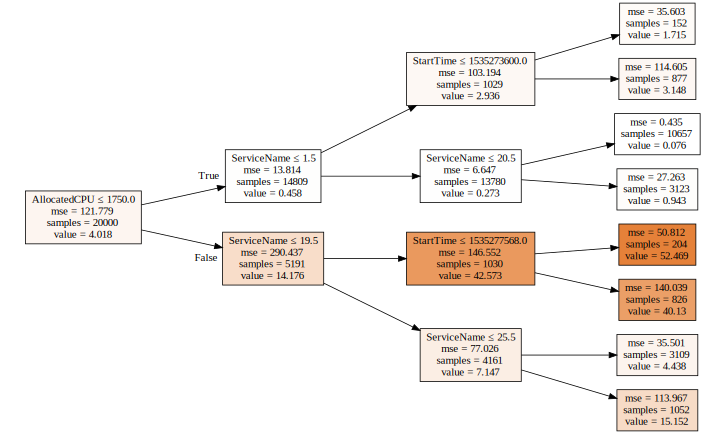

In [334]:
draw_tree(m.estimators_[0], df_trn, precision=3) 

In [335]:
m = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[array([0.18 , 0.02 , 0.02 , 0.025, 0.02 , 0.02 , 0.02 , 0.02 , 0.02 , 0.02 , 0.02 , 0.02 , 0.02 , 0.02 ,
       0.02 , 0.02 , 0.02 , 0.02 , 0.02 , 0.02 , ..., 0.04 , 0.04 , 0.03 , 0.03 , 0.04 , 0.04 , 0.06 , 0.03 ,
       0.04 , 0.04 , 0.03 , 0.03 , 0.03 , 0.04 , 0.08 , 0.03 , 0.03 , 0.05 , 0.04 , 0.03 ]), array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , ..., 0.11 , 0.11 , 0.12 , 0.12 , 0.12 , 0.1  , 0.11 , 0.11 ,
       0.12 , 0.12 , 0.11 , 0.125, 0.12 , 0.11 , 0.11 , 0.11 , 0.12 , 0.11 , 0.11 , 0.11 ]), 0.9582865341245537, -0.19336508715914635]


In [336]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([0.]), 0.0, 0.0)

In [337]:
preds.shape

(1, 12000)

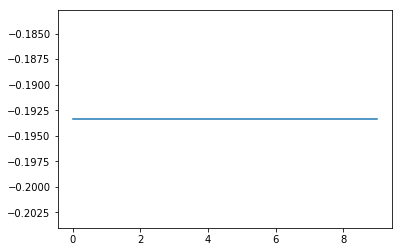

In [338]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);

In [339]:
data_df = pd.DataFrame(data, columns=["StartTime","ServiceName","AllocatedCPU", "HealthyHosts", "CPUAverage"])
label_col = "CPUAverage"

print(data_df.describe())

          StartTime  AllocatedCPU  HealthyHosts    CPUAverage
count  4.174500e+04  41745.000000  41745.000000  41745.000000
mean   1.535304e+09    827.785364      1.342125      3.042405
std    2.492436e+04    755.865285      0.823776      9.427975
min    1.535260e+09     25.000000      0.000000      0.000000
25%    1.535282e+09    200.000000      1.000000      0.010000
50%    1.535304e+09    500.000000      1.000000      0.060000
75%    1.535325e+09   1000.000000      2.000000      0.550000
max    1.535347e+09   3000.000000      6.000000    256.230000


In [56]:
def train_validate_test_split(df, train_part=.6, validate_part=.2, test_part=.2, seed=None):
    np.random.seed(seed)
    total_size = train_part + validate_part + test_part
    train_percent = train_part / total_size
    validate_percent = validate_part / total_size
    test_percent = test_part / total_size
    perm = np.random.permutation(df.index)
    m = len(df)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = perm[:train_end]
    validate = perm[train_end:validate_end]
    test = perm[validate_end:]
    return train, validate, test

In [62]:
train_size, valid_size, test_size = (70, 30, 0)
kc_train, kc_valid, kc_test = train_validate_test_split(data, 
                              train_part=train_size, 
                              validate_part=valid_size,
                              test_part=test_size,
                              seed=2017)

In [63]:
kc_y_train = data.loc[kc_train, [label_col]]
kc_x_train = data.loc[kc_train, :].drop(label_col, axis=1)
kc_y_valid = data.loc[kc_valid, [label_col]]
kc_x_valid = data.loc[kc_valid, :].drop(label_col, axis=1)

print('Size of training set: ', len(kc_x_train))
print('Size of validation set: ', len(kc_x_valid))
print('Size of test set: ', len(kc_test), '(not converted)')

Size of training set:  29196
Size of validation set:  12513
Size of test set:  1 (not converted)


In [64]:
def norm_stats(df1, df2):
    dfs = df1.append(df2)
    minimum = np.min(dfs)
    maximum = np.max(dfs)
    mu = np.mean(dfs)
    sigma = np.std(dfs)
    return (minimum, maximum, mu, sigma)

In [65]:
def z_score(col, stats):
    m, M, mu, s = stats
    df = pd.DataFrame()
    for c in col.columns:
        df[c] = (col[c]-mu[c])/s[c]
    return df

In [66]:
stats = norm_stats(kc_x_train, kc_x_valid)
arr_x_train = np.array(z_score(kc_x_train, stats))
arr_y_train = np.array(kc_y_train)
arr_x_valid = np.array(z_score(kc_x_valid, stats))
arr_y_valid = np.array(kc_y_valid)

print('Training shape:', arr_x_train.shape)
print('Training shape yaxis', arr_y_train.shape)
print('Training samples: ', arr_x_train.shape[0])
print('Validation samples: ', arr_x_valid.shape[0])

KeyError: 'ServiceName'

In [ ]:
def basic_model_1(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(100, activation="tanh", input_shape=(x_size,)))
    t_model.add(Dense(50, activation="relu"))
    t_model.add(Dense(y_size))
    print(t_model.summary())
    t_model.compile(loss='mean_squared_error',
        optimizer=Adam(),
        metrics=[metrics.mae])
    return(t_model)

In [ ]:
def basic_model_2(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(100, activation="tanh", input_shape=(x_size,)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(50, activation="relu"))
    t_model.add(Dense(20, activation="relu"))
    t_model.add(Dense(y_size))
    print(t_model.summary())
    t_model.compile(loss='mean_squared_error',
        optimizer=Adam(),
        metrics=[metrics.mae])
    return(t_model)

In [ ]:
def basic_model_3(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(80, activation="tanh", kernel_initializer='normal', input_shape=(x_size,)))
    t_model.add(Dropout(0.2))
    t_model.add(Dense(120, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1(0.01), bias_regularizer=regularizers.l1(0.01)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(20, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(10, activation="relu", kernel_initializer='normal'))
    t_model.add(Dropout(0.0))
    t_model.add(Dense(y_size))
    t_model.compile(
        loss='mean_squared_error',
        optimizer='nadam',
        metrics=[metrics.mae])
    return(t_model)

In [ ]:
model = basic_model_3(arr_x_train.shape[1], arr_y_train.shape[1])
model.summary()

In [ ]:
epochs = 1
batch_size = 128

print('Epochs: ', epochs)
print('Batch size: ', batch_size)

In [ ]:
keras_callbacks = [
    # ModelCheckpoint('/tmp/keras_checkpoints/model.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', save_best_only=True, verbose=2)
    # ModelCheckpoint('/tmp/keras_checkpoints/model.{epoch:02d}.hdf5', monitor='val_loss', save_best_only=True, verbose=0)
    # TensorBoard(log_dir='/tmp/keras_logs/model_3', histogram_freq=0, write_graph=True, write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None),
    EarlyStopping(monitor='val_mean_absolute_error', patience=20, verbose=0)
]

In [ ]:
history = model.fit(arr_x_train, arr_y_train,
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,
    verbose=0, # Change it to 2, if wished to observe execution
    validation_data=(arr_x_valid, arr_y_valid),
    callbacks=keras_callbacks)

In [ ]:
#print(arr_x_train)
#print(arr_y_train)

train_score = model.evaluate(arr_x_train, arr_y_train, verbose=1)
valid_score = model.evaluate(arr_x_valid, arr_y_valid, verbose=1)

print('Train MAE: ', round(train_score[1], 4), ', Train Loss: ', round(train_score[0], 4)) 
print('Val MAE: ', round(valid_score[1], 4), ', Val Loss: ', round(valid_score[0], 4))

In [37]:
def plot_hist(h, xsize=6, ysize=10):
    # Prepare plotting
    fig_size = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = [xsize, ysize]
    fig, axes = plt.subplots(nrows=4, ncols=4, sharex=True)
    
    # summarize history for MAE
    plt.subplot(211)
    plt.plot(h['mean_absolute_error'])
    plt.plot(h['val_mean_absolute_error'])
    plt.title('Training vs Validation MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # summarize history for loss
    plt.subplot(212)
    plt.plot(h['loss'])
    plt.plot(h['val_loss'])
    plt.title('Training vs Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot it all in IPython (non-interactive)
    plt.draw()
    plt.show()

    return

In [38]:
plot_hist(history.history, xsize=8, ysize=12)

NameError: name 'history' is not defined